In [18]:
#Objective: Predict the Determination column based on the content of the Findings column and possibly other metadata 
#(if needed, like Diagnosis Category, etc.)
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Load and Analyze Dataset
file_path = "C:/Users/Medha/Documents/CSUDH/Spring2025/Independent_Medical_Reviews.csv" 
df = pd.read_csv(file_path)

# Display dataset info
print("Dataset Shape:", df.shape)
print("Columns:", df.columns)
print("\n Is NULL:",df.isnull().sum())
#variable to predict - Determination
print('PREDICTION VALUES(Determination): ',df['Determination'].str.lower().unique())

# Step 2: Preprocessing
def clean_text(text):
    if pd.isnull(text):
        return ""  # Handle NaN values
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df["Cleaned_Text"] = df["Findings"].apply(clean_text)  # Assuming "Findings" contains the medical reviews

# Remove duplicates and short texts
df.drop_duplicates(subset=["Cleaned_Text"], inplace=True)
df = df[df["Cleaned_Text"].str.len() > 10]
df['text_length'] = df['Cleaned_Text'].apply(lambda x: len(str(x).split()))  # For Kaggle
print('\ntext_length\n',df['text_length'].describe())

print("Dataset shape after preprocessing: ", df.shape, df.columns)
print("\n Is NULL:",df.isnull().sum())

Dataset Shape: (19245, 11)
Columns: Index(['Reference ID', 'Report Year', 'Diagnosis Category',
       'Diagnosis Sub Category', 'Treatment Category',
       'Treatment Sub Category', 'Determination', 'Type', 'Age Range',
       'Patient Gender', 'Findings'],
      dtype='object')

 Is NULL: Reference ID                 0
Report Year                  0
Diagnosis Category          59
Diagnosis Sub Category    1904
Treatment Category         450
Treatment Sub Category    1268
Determination                0
Type                         0
Age Range                 1210
Patient Gender            1210
Findings                    20
dtype: int64
PREDICTION VALUES(Determination):  ['overturned decision of health plan' 'upheld decision of health plan']

text_length
 count    19130.000000
mean       177.758756
std        118.020549
min          2.000000
25%        103.000000
50%        153.000000
75%        218.000000
max       1077.000000
Name: text_length, dtype: float64
Dataset shape after pr

In [22]:
# Initialize counters 
empty_count = 0
nature_case_summary_count = 0
findings_count = 0
final_result_count = 0
total_count = 0
none_phrases_count = 0

# Loop through each cleaned text
for text in df['Findings']:
    if pd.isnull(text) or text.strip() == "":
        empty_count += 1
    else:
        total_count+=1
        found = False
        text_lower = text.lower()
        if "nature of statutory criteria/case summary:" in text_lower:
            nature_case_summary_count += 1
            found = True
        if "findings:" in text_lower:
            findings_count += 1
            found = True
        if "final result:" in text_lower:
            final_result_count += 1
            found = True
        if not found:
            none_phrases_count += 1

# Print results
print("Total Entries':", total_count)
print("Number of EMPTY entries in Cleaned_Text:", empty_count)
print("Entries with 'Nature of Statutory Criteria/Case Summary:':", nature_case_summary_count)
print("Entries with 'Findings:':", findings_count)
print("Entries with 'Final Result:':", final_result_count)
print("Entries with NONE of the 3 phrases:", none_phrases_count)

Total Entries': 19130
Number of EMPTY entries in Cleaned_Text: 0
Entries with 'Nature of Statutory Criteria/Case Summary:': 2483
Entries with 'Findings:': 13928
Entries with 'Final Result:': 2481
Entries with NONE of the 3 phrases: 4594


In [23]:
# Initialize counters
empty_count = 0
nature_case_summary_count = 0
findings_count = 0
final_result_count = 0
total_count = 0
none_phrases_count = 0

# Loop through each cleaned text
for text in df['Findings']:
    if pd.isnull(text) or text.strip() == "":
        empty_count += 1
    else:
        total_count+=1
        found = False
        text_lower = text.lower()
        if "nature of statutory criteria/case summary:" in text_lower:
            nature_case_summary_count += 1
            found = True
        elif "final result:" in text_lower:
            final_result_count += 1
            found = True
        elif "findings:" in text_lower:
            findings_count += 1
            found = True
        elif not found:
            none_phrases_count += 1

# Print results
print("Total Entries':", total_count)
print("Number of EMPTY entries in Cleaned_Text:", empty_count)
print("Entries with 'Nature of Statutory Criteria/Case Summary:':", nature_case_summary_count)
print("Entries with 'Findings:':", findings_count)
print("Entries with 'Final Result:':", final_result_count)
print("Entries with NONE of the 3 phrases:", none_phrases_count)

Total Entries': 19130
Number of EMPTY entries in Cleaned_Text: 0
Entries with 'Nature of Statutory Criteria/Case Summary:': 2483
Entries with 'Findings:': 12050
Entries with 'Final Result:': 3
Entries with NONE of the 3 phrases: 4594


In [13]:
import pandas as pd
import re

# Step 1: Extract key-value pairs from the Findings column
def extract_kv_pairs(text):
    pairs = {}
    if pd.isnull(text):
        return pairs
    lines = text.split('\n')
    print('lines:', lines)
    
    for line in lines:
        if ':' in line:
            key, value = line.split(':', 1)  # Only split on first colon
            key = key.strip().lower().replace(" ", "_")
            value = value.strip()
            if key and value:
                pairs[key] = value
            break
    return pairs

# Apply function to entire Findings column
df['kv_dict'] = df['Cleaned_Text'].apply(extract_kv_pairs)

# Step 2: Count number of key-value pairs
df['kv_count'] = df['kv_dict'].apply(len)

# Step 3: Convert all unique keys to new DataFrame columns
# First, collect all unique keys
from collections import defaultdict

all_keys = set()
for d in df['kv_dict']:
    all_keys.update(d.keys())

# Create new columns based on these keys
for key in all_keys:
    df[key] = df['kv_dict'].apply(lambda x: x.get(key, None))

# Optional: Drop kv_dict column if no longer needed
# df.drop(columns=['kv_dict'], inplace=True)
print("Dataset Shape:", df.shape)
print("Columns:", df.columns)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



['a yearold male requested participation in a clinical trial for the treatment of adenocarcinoma involving the columnarlined mucosa with intestinal metaplasia and squamous mucosa the health plan denied the request indicating the service is experimental the review organizations physician consultants examined the medical records submitted and determined the requested experimentalinvestigational treatment is more likely to be beneficial for the enrollee than any available standard treatment therefore the health plans denial should be overturned']
lines: ['a yearold female requested vertebral axial decompression therapy vaxd for the treatment of chronic lower back pain the health plan denied authorization indicating vaxd is considered experimental and is not likely to be more beneficial for the enrollee than any other available standard treatmentthe review organizations physician consultant examined the medical records submitted and determined that physical therapy chiropractic care or a t

Label Distribution:
 Cancer_Label
0    17247
1     1883
Name: count, dtype: int64
Model Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3438
           1       0.98      0.78      0.87       388

    accuracy                           0.98      3826
   macro avg       0.98      0.89      0.93      3826
weighted avg       0.98      0.98      0.97      3826



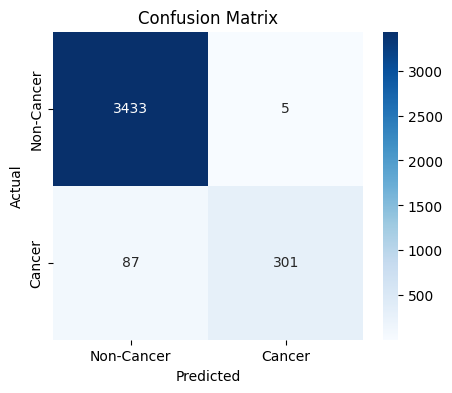

In [24]:
# Step 3: Create Labels (Cancer vs. Non-Cancer Classification)
df["Cancer_Label"] = df["Cleaned_Text"].str.contains("cancer", case=False, na=False).astype(int)

# Check label distribution
print("Label Distribution:\n", df["Cancer_Label"].value_counts())

# Step 4: Train Logistic Regression Model
# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["Cleaned_Text"])
y = df["Cancer_Label"]

# Split dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Cancer", "Cancer"], yticklabels=["Non-Cancer", "Cancer"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


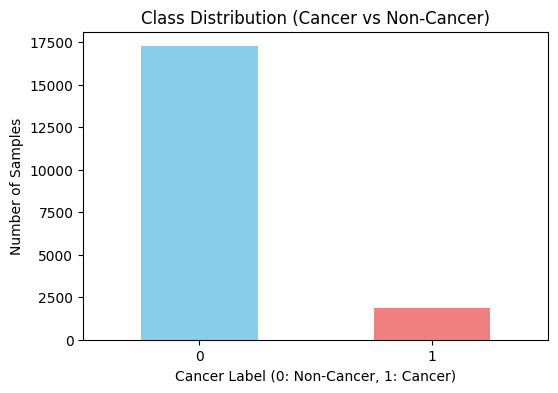



Confusion matrix




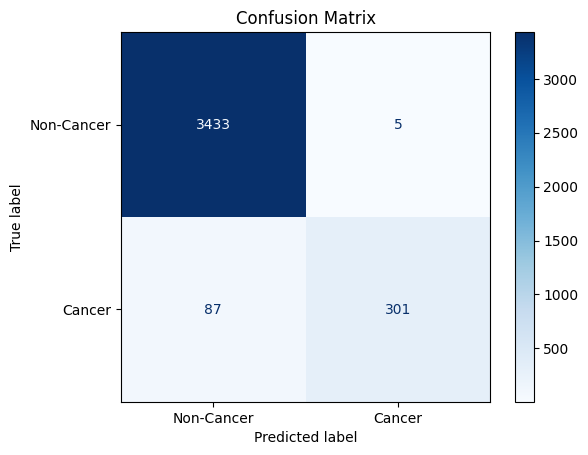



classification_report

               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3438
           1       0.98      0.78      0.87       388

    accuracy                           0.98      3826
   macro avg       0.98      0.89      0.93      3826
weighted avg       0.98      0.98      0.97      3826



In [3]:
import matplotlib.pyplot as plt

# Plot class distribution
plt.figure(figsize=(6, 4))
df['Cancer_Label'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Class Distribution (Cancer vs Non-Cancer)')
plt.xlabel('Cancer Label (0: Non-Cancer, 1: Cancer)')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print('\n\nConfusion matrix\n\n')
# Confusion matrix
y_pred = model.predict(X_test)  # Replace with your model's predictions
cm = confusion_matrix(y_test, y_pred)  # Replace y_test with your actual test labels

# Plot confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Cancer', 'Cancer'])
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import classification_report

# Print classification report
print('\n\nclassification_report\n\n',classification_report(y_test, y_pred))


In [16]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

print('FIXING CLASS IMBALANCE\n\n')


# Split data into training and testing sets (if not already done)
X = df['Findings']  # Assuming 'Findings' is the feature column
y = df['Cancer_Label']  # Assuming 'Cancer_Label' is the target column

# Preprocessing: Convert text to numeric data (e.g., using TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=20000)
X_tfidf = tfidf.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"Resampled dataset shape: {y_train_res.value_counts()}")

print('\n\n TRAINING BALANCED DATASET\n\n')
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Train the Logistic Regression model on the resampled data
model_smote = LogisticRegression(random_state=42, max_iter=1000)
model_smote.fit(X_train_res, y_train_res)

# Make predictions on the test set
y_pred_smote = model_smote.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred_smote))

print("ADJUSTING SAMPLING STRATEGY AND LOGISTIC REGRESSION")
smote = SMOTE(sampling_strategy=0.7, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"Resampled dataset shape: {y_train_res.value_counts()}")

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Train the Logistic Regression model on the resampled data
model_smote = LogisticRegression(C=0.5, solver='liblinear', random_state=42, max_iter=1000)
model_smote.fit(X_train_res, y_train_res)

# Make predictions on the test set
y_pred_smote = model_smote.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred_smote))

FIXING CLASS IMBALANCE


Resampled dataset shape: Cancer_Label
0    13798
1    13798
Name: count, dtype: int64


 TRAINING BALANCED DATASET


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3449
           1       0.92      0.92      0.92       377

    accuracy                           0.98      3826
   macro avg       0.96      0.96      0.96      3826
weighted avg       0.98      0.98      0.98      3826

ADJUSTING SAMPLING STRATEGY AND LOGISTIC REGRESSION
Resampled dataset shape: Cancer_Label
0    13798
1     9658
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3449
           1       0.91      0.89      0.90       377

    accuracy                           0.98      3826
   macro avg       0.95      0.94      0.95      3826
weighted avg       0.98      0.98      0.98      3826



Cancer_Label
0    17247
1     1883
Name: count, dtype: int64
